In [2]:
!pip install tslearn==0.6.3

In [3]:
import numpy as np
import pandas as pd
from tslearn.metrics import cdist_soft_dtw
from sklearn.metrics import silhouette_score
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import soft_dtw
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
from scipy.interpolate import PchipInterpolator

In [4]:
import matplotlib.pyplot as plt

In [5]:
from tslearn.clustering import KShape
from sklearn.metrics import adjusted_rand_score

In [6]:
from tslearn.metrics import cdist_dtw
from sklearn.cluster import KMeans
from sklearn.manifold import MDS

In [7]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import adjusted_rand_score

# 读取与整理数据（透视为 城市×年份 的矩阵）

In [8]:
# 依次读取
df2006 = pd.read_excel("df_2006_result.xlsx")
df2010 = pd.read_excel("df_2010_result.xlsx")
df2014 = pd.read_excel("df_2014_result.xlsx")
df2018 = pd.read_excel("df_2018_result.xlsx")
df2022 = pd.read_excel("df_2022_result.xlsx")

# 合并成一个大表
df = pd.concat([df2006, df2010, df2014, df2018, df2022], ignore_index=True)

In [9]:
df

,Citycode,Year,UER,UI,C,T,D,UI_normalized,UER_normalized,C2,T2,D2
0,110000,2006,0.597028,0.413019,0.983266,0.505024,0.704679,0.421771,0.965356,0.920017,0.693564,0.798806
1,120000,2006,0.251036,0.466516,0.953845,0.358776,0.584993,0.479557,0.353926,0.988575,0.416741,0.641857
2,130100,2006,0.205372,0.278505,0.988512,0.241938,0.489039,0.276473,0.273230,0.999983,0.274852,0.524258
3,130200,2006,0.199356,0.299177,0.979749,0.249267,0.494185,0.298803,0.262599,0.997918,0.280701,0.529261
4,130300,2006,0.148666,0.209243,0.985573,0.178954,0.419967,0.201659,0.173021,0.997075,0.187340,0.432194
...,...,...,...,...,...,...,...,...,...,...,...,...
1385,640300,2022,0.107660,0.058487,0.955200,0.083074,0.281695,0.022669,0.033894,0.980110,0.028281,0.166490
1386,640400,2022,0.129846,0.063991,0.940517,0.096919,0.301917,0.028763,0.062040,0.930427,0.045402,0.205531
1387,640500,2022,0.107002,0.073533,0.982665,0.090268,0.297830,0.039329,0.033059,0.996243,0.036194,0.189890
1388,650100,2022,0.106822,0.174135,0.970875,0.140478,0.369306,0.150723,0.032830,0.766469,0.091777,0.265224


In [10]:
# 去掉 NaN 行（如果需要）
df = df.dropna()

In [7]:
df.to_csv("CCI_06_22.csv", index=False)

In [11]:

# 仅保留需要的列；若你的列名不同，请替换
df = df[['Citycode', 'Year', 'D']].copy()

# 去除重复、排序
df = df.drop_duplicates(subset=['Citycode','Year']).sort_values(['Citycode','Year'])

# 透视为矩阵：每行一个城市，每列一个年份；值为 D（CCI）
mat = df.pivot(index='Citycode', columns='Year', values='D')

# 确保年份顺序（你是 2006、2010、2014、2018、2020）
mat = mat.reindex(columns=sorted(mat.columns))
years = mat.columns.to_list()

print(mat.shape, years)
# (n_cities, 5)  e.g. (285, 5)

(278, 5) [2006, 2010, 2014, 2018, 2022]


In [12]:
mat

Year,2006,2010,2014,2018,2022
Citycode,,,,,
110000,0.704679,0.711124,0.760581,0.719679,0.776729
120000,0.584993,0.612871,0.669002,0.597073,0.566236
130100,0.489039,0.471600,0.423396,0.429604,0.451652
130200,0.494185,0.500234,0.449859,0.452409,0.457650
130300,0.419967,0.398744,0.396221,0.404766,0.403984
...,...,...,...,...,...
640300,0.303744,0.286069,0.286635,0.294359,0.281695
640400,0.269442,0.242435,0.254914,0.278223,0.301917
640500,0.311429,0.251850,0.272561,0.276530,0.297830


In [13]:
print("mat NaN 总数:", mat.isna().sum().sum())
print("每个城市缺失值个数 top10:\n", mat.isna().sum(axis=1).sort_values(ascending=False).head(10))

mat NaN 总数: 0
每个城市缺失值个数 top10:
 Citycode
110000    0
440300    0
440900    0
440800    0
440700    0
440600    0
440500    0
440400    0
440200    0
430700    0
dtype: int64


In [14]:
mat_clean = mat.dropna()   # 删除任何含 NaN 的城市
print("剩余城市数:", mat_clean.shape[0])

剩余城市数: 278


In [15]:
mat_clean

Year,2006,2010,2014,2018,2022
Citycode,,,,,
110000,0.704679,0.711124,0.760581,0.719679,0.776729
120000,0.584993,0.612871,0.669002,0.597073,0.566236
130100,0.489039,0.471600,0.423396,0.429604,0.451652
130200,0.494185,0.500234,0.449859,0.452409,0.457650
130300,0.419967,0.398744,0.396221,0.404766,0.403984
...,...,...,...,...,...
640300,0.303744,0.286069,0.286635,0.294359,0.281695
640400,0.269442,0.242435,0.254914,0.278223,0.301917
640500,0.311429,0.251850,0.272561,0.276530,0.297830


# 测试缺失值处理与可选的 PCHIP 插值（把5点变9点，非必须）

In [12]:
# ---- 2.2 可选：PCHIP 在相邻两点间补一个中点 ----
use_pchip = True  # 想要9点时改为 True
if use_pchip:
    base_t = np.array(years, dtype=float)  # [2006, 2010, 2014, 2018, 2020]
    mid_t = []
    for i in range(len(base_t)-1):
        mid_t.append((base_t[i]+base_t[i+1])/2)
    new_t = np.sort(np.concatenate([base_t, np.array(mid_t)]))  # 9个时间点

    def pchip_to_midpoints(values):
        # values shape=(5,)
        f = PchipInterpolator(base_t, values)
        return pd.Series(f(new_t), index=new_t)

    mat_long = mat_clean.apply(lambda r: pchip_to_midpoints(r.values), axis=1)
    mat_long.columns = mat_long.columns.astype(int)  # 2006,2008,2010,2012,2014,2016,2018,2019,2020
    mat_use = mat_long
    years_use = mat_long.columns.to_list()
else:
    mat_use = mat_clean
    years_use = years

print(mat_use.shape, years_use)

(288, 9) [2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020, 2022]


# z-score 标准化（行内/全局二选一）

In [16]:
# ---- 3.1 行内 z-score（默认）----
def zscore_row(row: pd.Series):
    arr = row.values.astype(float)
    mu, sigma = np.nanmean(arr), np.nanstd(arr)
    if sigma == 0:
        return pd.Series(np.zeros_like(arr), index=row.index)
    return pd.Series((arr - mu) / sigma, index=row.index)

Z_row = mat_clean.apply(zscore_row, axis=1)

# ---- 3.2 全局 z-score（若需要）----
use_global = False
if use_global:
    mu_g = np.nanmean(Z_row.values)  # 这里也可以直接对 mat_use 做全局z
    sigma_g = np.nanstd(Z_row.values)
    Z = (Z_row - mu_g) / (sigma_g if sigma_g != 0 else 1.0)
else:
    Z = Z_row

# 转为 tslearn 需要的 3D： (n_samples, n_timestamps, n_features=1)
X = Z.values.astype(float)
X = X.reshape((X.shape[0], X.shape[1], 1))
city_ids = Z.index.to_numpy()

# 选择 soft-DTW 的 γ（平滑度）并扫描 K

In [33]:
# γ 的经验估计
median_std = np.median(np.std(Z.values, axis=1))
T = X.shape[1]
gamma = max(1e-3, 0.1 * median_std * T)   # 经验值，可再微调
print("Heuristic gamma =", gamma)

# 扫描 K，计算基于 soft-DTW 距离的 silhouette（预计算距离）
dmat = cdist_soft_dtw(X.squeeze(-1), gamma=gamma)  # (n, n)

# 强制对角线为 0
np.fill_diagonal(dmat, 0.0)
dmat[dmat < 0] = 0.0   # 把所有负数裁剪为 0
def try_k(k):
    km = TimeSeriesKMeans(n_clusters=k, metric="softdtw",
                          metric_params={"gamma": gamma},
                          n_init=5, max_iter_barycenter=50,
                          random_state=42, verbose=False)
    labels = km.fit_predict(X)
    sil = silhouette_score(dmat, labels, metric="precomputed")
    inertia = km.inertia_
    return sil, inertia, km, labels

results = []
for k in range(2, 7):  # 可按需扩大范围
    sil, inertia, km, labels = try_k(k)
    results.append((k, sil, inertia, km, labels))
    print(f"K={k}: silhouette={sil:.3f}, inertia={inertia:.3f}")

# 选一个“silhouette较高且直观”的K
best_k, best_sil, _, best_km, best_labels = max(results, key=lambda x: x[1])
print("Chosen K =", best_k, " (silhouette =", round(best_sil,3), ")")

Heuristic gamma = 0.5
K=2: silhouette=0.750, inertia=1.699
K=3: silhouette=0.697, inertia=1.084
K=4: silhouette=0.650, inertia=0.904
K=5: silhouette=0.559, inertia=0.829
K=6: silhouette=0.541, inertia=0.716
Chosen K = 2  (silhouette = 0.75 )


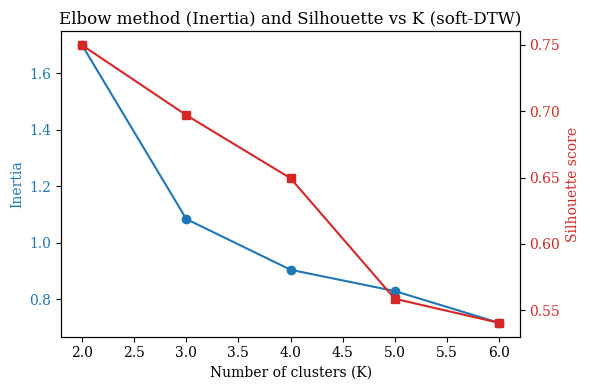

In [35]:
K = range(2, 7)
sils = [r[1] for r in results]
inertias = [r[2] for r in results]

fig, ax1 = plt.subplots(figsize=(6,4))

color = "tab:blue"
ax1.set_xlabel("Number of clusters (K)")
ax1.set_ylabel("Inertia", color=color)
ax1.plot(list(K), inertias, "-o", color=color, label="Inertia")
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()  # 共用x轴
color = "tab:red"
ax2.set_ylabel("Silhouette score", color=color)
ax2.plot(list(K), sils, "-s", color=color, label="Silhouette")
ax2.tick_params(axis="y", labelcolor=color)

plt.title("Elbow method (Inertia) and Silhouette vs K (soft-DTW)")
fig.tight_layout()


plt.savefig("Elbow method.png", dpi=900, bbox_inches="tight")
plt.show()

In [19]:
labels = best_labels
centers = best_km.cluster_centers_.squeeze(-1)  # shape=(K, T)

# 典型城市 Top-5（到各自簇质心的 soft-DTW 距离最小）
def top_cities_for_cluster(c):
    idx = np.where(labels == c)[0]
    if len(idx) == 0:
        return []
    series_c = X[idx].squeeze(-1)
    center = centers[c]
    dists = [soft_dtw(s, center, gamma=gamma) for s in series_c]
    order = np.argsort(dists)[:min(5, len(idx))]
    return list(city_ids[idx[order]])

top5_by_cluster = {c: top_cities_for_cluster(c) for c in range(best_k)}

# 保存标签
out_labels = pd.DataFrame({"Citycode": city_ids, "cluster": labels})
# out_labels.to_csv("cci_softdtw_kmeans_labels.csv", index=False)

# 原型轨迹（中心）
proto = pd.DataFrame(centers, columns=years)
proto["cluster"] = range(best_k)
# proto.to_csv("cci_softdtw_prototypes.csv", index=False)

print(top5_by_cluster)

{0: [510800, 530600, 410600, 621200, 360700], 1: [210600, 141000, 610500, 530300, 140300], 2: [360600, 620300, 130100, 130200, 620400]}


In [21]:
out_labels

,Citycode,cluster
0,110000,0
1,120000,1
2,130100,2
3,130200,2
4,130300,2
...,...,...
273,640300,2
274,640400,0
275,640500,2
276,650100,2


# 可视化：各簇原型轨迹 + 95% 置信带（近似）

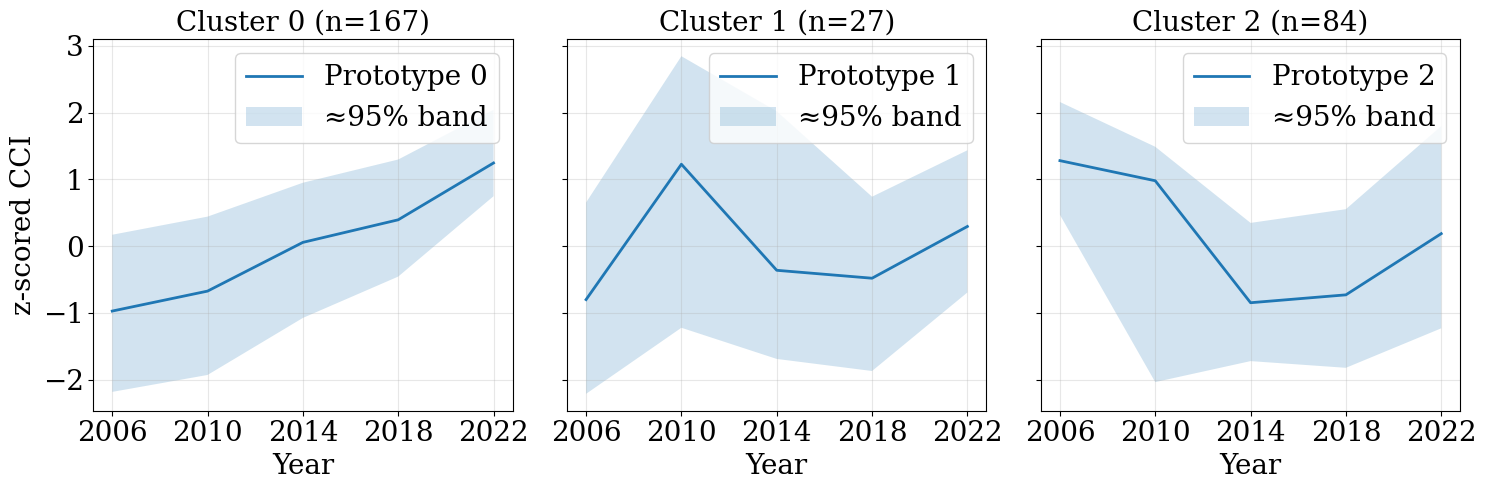

In [30]:
# 设置字体
plt.rcParams["font.family"] = "DejaVu Serif"

# 计算每簇逐点均值和std（在原始时间点上）
cluster_curves = {c: Z.values[labels==c] for c in range(best_k)}
mean_curves = {c: np.nanmean(cluster_curves[c], axis=0) if len(cluster_curves[c])>0 else np.nan*np.zeros(Z.shape[1])
               for c in range(best_k)}
std_curves  = {c: np.nanstd (cluster_curves[c], axis=0) if len(cluster_curves[c])>0 else np.nan*np.zeros(Z.shape[1])
               for c in range(best_k)}

# 调整图片大小
fig, axes = plt.subplots(1, best_k, figsize=(5*best_k, 5), sharey=True)
if best_k == 1:
    axes = [axes]

for c, ax in enumerate(axes):
    # 原型（质心）曲线
    ax.plot(years, centers[c], linewidth=2, label=f"Prototype {c}")

    # 置信带（近似）
    mu, sd = mean_curves[c], std_curves[c]
    upper = mu + 1.96*sd
    lower = mu - 1.96*sd
    ax.fill_between(years, lower, upper, alpha=0.2, label="≈95% band")

    ax.set_title(f"Cluster {c} (n={np.sum(labels==c)})", fontsize=20)
    ax.set_xlabel("Year", fontsize=20)
    if c == 0:
        ax.set_ylabel("z-scored CCI", fontsize=20)

    # 设置横坐标刻度
    ax.set_xticks([2006, 2010, 2014, 2018, 2022])

    ax.tick_params(axis='both', labelsize=20)
    ax.grid(True, alpha=.3)
    ax.legend(fontsize=20)

plt.tight_layout()

# 输出图片
plt.savefig("cluster_curves.png", dpi=900, bbox_inches="tight")
# plt.savefig("cluster_curves.pdf", bbox_inches="tight")  # 如果需要矢量图

plt.show()

In [30]:
def recluster_with_subset(X_sub, K, gamma):
    km = TimeSeriesKMeans(n_clusters=K, metric="softdtw",
                          metric_params={"gamma": gamma},
                          n_init=3, max_iter_barycenter=30, random_state=0)
    return km.fit_predict(X_sub)

def jaccard_on_pairs(labels1, labels2):
    # 计算成对一致的Jaccard（同簇对/并集对）
    n = len(labels1)
    same1 = np.equal.outer(labels1, labels1)
    same2 = np.equal.outer(labels2, labels2)
    # 只统计上三角
    iu = np.triu_indices(n, 1)
    inter = np.logical_and(same1, same2)[iu].sum()
    union = np.logical_or(same1, same2)[iu].sum()
    return inter / union if union>0 else 1.0

base_labels = labels

# ---- 7.1 留一年：每次去掉一个时间点 ----
aris, jacs = [], []
for drop_col in range(X.shape[1]):
    X_drop = np.delete(X, drop_col, axis=1)
    lab2 = recluster_with_subset(X_drop, best_k, gamma)
    ari = adjusted_rand_score(base_labels, lab2)
    jac = jaccard_on_pairs(base_labels, lab2)
    aris.append(ari); jacs.append(jac)
    print(f"LOO drop t#{drop_col} -> ARI={ari:.3f}, Jaccard={jac:.3f}")

print("LOO mean ARI =", np.mean(aris), "; mean Jaccard =", np.mean(jacs))

# ---- 7.2 轻噪声：z后序列加很小高斯噪声 ----
np.random.seed(0)
noise_level = 0.05  # 调小一些
X_noisy = X + noise_level*np.std(X, axis=(0,1))*np.random.randn(*X.shape)
lab3 = recluster_with_subset(X_noisy, best_k, gamma)
ari3 = adjusted_rand_score(base_labels, lab3)
jac3 = jaccard_on_pairs(base_labels, lab3)
print(f"Jitter -> ARI={ari3:.3f}, Jaccard={jac3:.3f}")

LOO drop t#0 -> ARI=0.297, Jaccard=0.407
LOO drop t#1 -> ARI=0.569, Jaccard=0.617
LOO drop t#2 -> ARI=0.935, Jaccard=0.933
LOO drop t#3 -> ARI=0.524, Jaccard=0.550
LOO drop t#4 -> ARI=0.793, Jaccard=0.791
LOO mean ARI = 0.6238210079629385 ; mean Jaccard = 0.6595198604974415
Jitter -> ARI=0.971, Jaccard=0.969


In [16]:
#K=2 结果很低

def recluster_with_subset(X_sub, K, gamma):
    km = TimeSeriesKMeans(n_clusters=K, metric="softdtw",
                          metric_params={"gamma": gamma},
                          n_init=3, max_iter_barycenter=30, random_state=0)
    return km.fit_predict(X_sub)

def jaccard_on_pairs(labels1, labels2):
    # 计算成对一致的Jaccard（同簇对/并集对）
    n = len(labels1)
    same1 = np.equal.outer(labels1, labels1)
    same2 = np.equal.outer(labels2, labels2)
    # 只统计上三角
    iu = np.triu_indices(n, 1)
    inter = np.logical_and(same1, same2)[iu].sum()
    union = np.logical_or(same1, same2)[iu].sum()
    return inter / union if union>0 else 1.0

base_labels = labels

# ---- 7.1 留一年：每次去掉一个时间点 ----
aris, jacs = [], []
for drop_col in range(X.shape[1]):
    X_drop = np.delete(X, drop_col, axis=1)
    lab2 = recluster_with_subset(X_drop, best_k, gamma)
    ari = adjusted_rand_score(base_labels, lab2)
    jac = jaccard_on_pairs(base_labels, lab2)
    aris.append(ari); jacs.append(jac)
    print(f"LOO drop t#{drop_col} -> ARI={ari:.3f}, Jaccard={jac:.3f}")

print("LOO mean ARI =", np.mean(aris), "; mean Jaccard =", np.mean(jacs))

# ---- 7.2 轻噪声：z后序列加很小高斯噪声 ----
np.random.seed(0)
noise_level = 0.05  # 调小一些
X_noisy = X + noise_level*np.std(X, axis=(0,1))*np.random.randn(*X.shape)
lab3 = recluster_with_subset(X_noisy, best_k, gamma)
ari3 = adjusted_rand_score(base_labels, lab3)
jac3 = jaccard_on_pairs(base_labels, lab3)
print(f"Jitter -> ARI={ari3:.3f}, Jaccard={jac3:.3f}")

LOO drop t#0 -> ARI=0.235, Jaccard=0.317
LOO drop t#1 -> ARI=0.345, Jaccard=0.379
LOO drop t#2 -> ARI=0.359, Jaccard=0.387
LOO drop t#3 -> ARI=0.353, Jaccard=0.383
LOO drop t#4 -> ARI=0.325, Jaccard=0.364
LOO mean ARI = 0.3234838892778102 ; mean Jaccard = 0.3660030486441428
Jitter -> ARI=0.358, Jaccard=0.387


In [23]:
out_labels.to_csv("labels_noprovin0911.csv", index=False)

In [40]:
# DBA-k-means 实现（旧版 tslearn 里就是 metric="dtw"）

# 为了验证稳健性，我们进一步采用了经典的 DBA-k-means（DTW 距离下的均值聚类）。与 Soft-DTW 聚类结果相比，两者在城市分簇模式上保持了中等一致性（ARI≈0.50, Jaccard≈0.55），说明结论具有跨方法的稳健性，并不依赖于单一的距离度量。
km_dba = TimeSeriesKMeans(
    n_clusters=best_k,
    metric="dtw",                 # 用 DTW 距离
    n_init=3,
    max_iter_barycenter=50,
    random_state=0,
    verbose=False
)

labels_dba = km_dba.fit_predict(X_dba)

# 与 Soft-DTW 结果对比
ari_dba = adjusted_rand_score(base_labels, labels_dba)
jac_dba = jaccard_on_pairs(base_labels, labels_dba)

print(f"[DBA-k-means vs Soft-DTW] ARI={ari_dba:.3f}, Jaccard={jac_dba:.3f}")

[DBA-k-means vs Soft-DTW] ARI=0.496, Jaccard=0.550
